In [1]:
!python -m pip install --upgrade pip -q
!pip install transformers==4.38.1 -q -U
!pip install bitsandbytes==0.42.0 -q -U
!pip install peft==0.8.2 -q -U
!pip install accelerate==0.27.2 -q -U
!pip install flash-attn==2.5.5 -q -U
!pip install datasets==2.17.1 -q -U
!pip install scipy==1.12.0 -q -U
!pip install trl==0.7.11 -q -U
!pip install hf_transfer==0.1.5 -q -U
!pip install huggingface_hub==0.20.3 -q -U
!pip install wandb==0.16.3 -q -U


!transformers-cli env


Copy-and-paste the text below in your GitHub issue and FILL OUT the two last points.

- `transformers` version: 4.38.1
- Platform: Linux-5.4.0-153-generic-x86_64-with-glibc2.35
- Python version: 3.10.12
- Huggingface_hub version: 0.20.3
- Safetensors version: 0.4.3
- Accelerate version: 0.27.2
- Accelerate config: 	not found
- PyTorch version (GPU?): 2.1.1+cu121 (True)
- Tensorflow version (GPU?): not installed (NA)
- Flax version (CPU?/GPU?/TPU?): not installed (NA)
- Jax version: not installed
- JaxLib version: not installed
- Using GPU in script?: <fill in>
- Using distributed or parallel set-up in script?: <fill in>



In [2]:
# Required when training models/data that are gated on HuggingFace, and required for pushing models to HuggingFace
from huggingface_hub import notebook_login
notebook_login()

In [3]:
%env HF_HUB_ENABLE_HF_TRANSFER=True

env: HF_HUB_ENABLE_HF_TRANSFER=True


In [4]:
cache_dir='' 
# model_id = "meta-llama/Llama-2-7b-hf"
# model_id = "meta-llama/Llama-2-7b-chat-hf"
# model_id = "meta-llama/Llama-2-13b-chat-hf"
# model_id = "mistralai/Mistral-7B-Instruct-v0.1"
model_id = "NousResearch/Meta-Llama-3-8B-Instruct"
# model_id = "Qwen/Qwen1.5-7B-Chat"

In [5]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoConfig
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

config = AutoConfig.from_pretrained(model_id)
config.max_position_embeddings = 4096 

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map='auto',
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2", 
    cache_dir=cache_dir)

tokenizer = AutoTokenizer.from_pretrained(model_id,use_fast=True,trust_remote_code=True)

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/126 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
for n, p in model.named_parameters():
    if p.device.type == "meta":
        print(f"{n} is on meta!")

In [7]:
print(model.config.max_position_embeddings)
print(model.config.eos_token_id)

8192
128001


In [8]:
def print_trainable_parameters(model):
    """
    Printed die Zahl der trainierbaren Parameter
    """
    trainable_params = 0
    non_trainable_params = 0
    all_params = 0

    print("Trainable Parameters:")
    for name, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
            print(f"  {name}")
        else:
            non_trainable_params += param.numel()

    print("\nNon-Trainable Parameters:")
    for name, param in model.named_parameters():
        if not param.requires_grad:
            print(f"  {name}")

    print(
        f"\nSummary:\n  Trainable params: {trainable_params}\n  Non-Trainable params: {non_trainable_params}\n  All params: {all_params}\n  Trainable%: {100 * trainable_params / all_params}"
    )

In [12]:
# print(model)

In [9]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable() #Zum speichern von VRAM
# model = prepare_model_for_kbit_training(model) # Fuer Quantisierung

from peft import LoraConfig, get_peft_model

peft_config = LoraConfig( #matching the Llama recipe
    r=8,
    lora_alpha=32,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        # "self_attn.rotary_emb.inv_freq",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
    # use_dora=True # only for DoRA
)

model = get_peft_model(model, peft_config) #move to a peft model

In [12]:
print_trainable_parameters(model)

Trainable Parameters:
  base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight
  base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight
  base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight
  base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight
  base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight
  base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight
  base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight
  base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight
  base_model.model.model.layers.0.mlp.gate_proj.lora_A.default.weight
  base_model.model.model.layers.0.mlp.gate_proj.lora_B.default.weight
  base_model.model.model.layers.0.mlp.up_proj.lora_A.default.weight
  base_model.model.model.layers.0.mlp.up_proj.lora_B.default.weight
  base_model.model.model.layers.0.mlp.down_proj.lora_A.default.weight
  base_model.model.model.layers.0.mlp.down_proj.

In [10]:
print(tokenizer)
print(tokenizer.vocab_size)

PreTrainedTokenizerFast(name_or_path='NousResearch/Meta-Llama-3-8B-Instruct', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|end_of_text|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|reserved_special_token_2|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128005: Adde

In [11]:
print(tokenizer.bos_token)
print(tokenizer.eos_token)

<|begin_of_text|>
<|end_of_text|>


In [12]:
#Chat Template testen
messages=[
    { 'role': 'user', 'content': "write a quick sort algorithm in python."},
    { 'role': 'assistant', 'content': "here you are."},
    { 'role': 'user', 'content': "great."},
]

inputs = tokenizer.apply_chat_template(messages, tokenize=False)
print(inputs)

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

write a quick sort algorithm in python.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

here you are.<|eot_id|><|start_header_id|>user<|end_header_id|>

great.<|eot_id|><|end_of_text|>


In [13]:
## OPTION A - set the pad token to <pad>, if not <|pad|>, if not <unk> if <unk> is in the tokenizer OR set it to the EOS token.
if '<pad>' in tokenizer.get_vocab():
    print('<pad> token is in the tokenizer. Using <pad> for pad')
    # Set the pad token
    tokenizer.pad_token = '<pad>'
elif '<|pad|>' in tokenizer.get_vocab():
    print('<|pad|> token is in the tokenizer. Using <|pad|> for pad')
    # Set the pad token
    tokenizer.pad_token = '<|pad|>'
elif '<unk>' in tokenizer.get_vocab():
    print('<unk> token is in the tokenizer. Using unk for pad')
    # Set the pad token
    tokenizer.pad_token = '<unk>'
else:
    print(f'Using EOS token, {tokenizer.eos_token}, for padding. WARNING, this may not be ideal for chat fine-tuning models.')
    tokenizer.pad_token = tokenizer.eos_token

Using EOS token, <|end_of_text|>, for padding. WARNING, this may not be ideal for chat fine-tuning models.


In [14]:
# Update pad token id in model und die config
model.pad_token_id = tokenizer.pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# Checken ob sie gleich sind
assert model.pad_token_id == tokenizer.pad_token_id, "The model's pad token ID does not match the tokenizer's pad token ID!"

# Printe die pad token ids
print('Tokenizer pad token ID:', tokenizer.pad_token_id)
print('Model pad token ID:', model.pad_token_id)
print('Model config pad token ID:', model.config.pad_token_id)
print('Number of tokens now in tokenizer:', tokenizer.vocab_size)

Tokenizer pad token ID: 128001
Model pad token ID: 128001
Model config pad token ID: 128001
Number of tokens now in tokenizer: 128000


In [15]:
print("Special tokens map:", tokenizer.special_tokens_map)

Special tokens map: {'bos_token': '<|begin_of_text|>', 'eos_token': '<|end_of_text|>', 'pad_token': '<|end_of_text|>'}


In [16]:
from transformers import TextStreamer
from peft import PeftModel
import torch
import gc  # 

# Definiere einen stream
def stream(user_prompt, model_type, tokenizer, checkpoint=''):

    if model_type == 'base':
        eval_model = model
    elif model_type == 'fine-tuned':
        eval_model = PeftModel.from_pretrained(model, checkpoint) 
        eval_model = eval_model.to("cuda")

        for n, p in eval_model.named_parameters():
            if p.device.type == "cpu":
                print(f"{n} is on cpu!")
        
    else:
        print('You must set the model_type to base or fine-tuned')
        exit()  

   
    eval_model.config.use_cache = True

    messages=[
        { 'role': 'user', 'content': f"{user_prompt.strip()}"},
    ]
    
    inputs = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    inputs = tokenizer([inputs], return_tensors="pt", add_special_tokens=False).to("cuda")

    if "token_type_ids" in inputs:
        del inputs["token_type_ids"]
    
    streamer = TextStreamer(tokenizer)

    print(f'eval_model is on: {next(eval_model.parameters()).device}')  # Debug line
    print(f'input_ids are on: {inputs["input_ids"].device}')  # Debug line


    _ = eval_model.generate(**inputs, streamer=streamer, max_new_tokens=100, do_sample=False, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id)
    
   
    torch.cuda.empty_cache()  
    gc.collect()  # Lass garbage collection laufen


def evaluation(model_type, tokenizer, checkpoint=''):
    questions = [
        "What does Bitcoin mining achieve?",
        "How are Bitcoin transactions verified?",
        "What is the function of a Bitcoin wallet?",
        "What triggers Bitcoin's price change?",
        "What is a Bitcoin hard fork?"
    ]

    answers = [
         "Validates transactions and secures the network by adding new blocks to the blockchain through solving SHA-256 hash problems.",
        "Through digital signatures created with a sender's private key and confirmed by network nodes using the corresponding public key.",
        "Manages private keys for signing transactions and tracks associated public addresses for receiving Bitcoin.",
        "Supply and demand dynamics, influenced by factors like mining halvings, network activity, and macroeconomic indicators.",
        "A protocol upgrade that splits the blockchain into two paths: one following new rules (incompatible with old software) and the original continuing as before."
    ]

    for question, answer in zip(questions, answers):
        stream(question, model_type, tokenizer, checkpoint)
        print("Correct Answer:", answer)
        print('\n\n')

In [18]:
print(model.generation_config)

GenerationConfig {
  "bos_token_id": 128000,
  "eos_token_id": 128001
}



In [19]:
evaluation("base", tokenizer)

eval_model is on: cuda:0
input_ids are on: cuda:0
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

What does Bitcoin mining achieve?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Bitcoin mining is the process of verifying and adding new transactions to the public ledger called the blockchain, while also solving complex mathematical problems to validate the transactions and secure the network. The main goals of Bitcoin mining are:

1. **Verification of transactions**: Miners collect and verify a group of unconfirmed transactions, known as a block, to ensure that they are valid and legitimate. This involves checking that the sender has the necessary funds, that the transaction is properly formatted, and that the transaction is not attempting
Correct Answer: Validates transactions and secures the network by adding new blocks to the blockchain through solving SHA-256 hash problems.



eval_model is on: cuda:0
input_ids are on: cuda:0
<|begin_of_text|><|start_header_id|>

In [20]:

from datasets import load_dataset

dataset="SolaireOfTheSun/BioDHBWleichtVerbessertDeutsch"

data = load_dataset(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [21]:
print("First row of train:", data['train'][1])

First row of train: {'messages': '{"messages": [{"role": "user", "content": "Welche gemeinsamen Merkmale unterscheiden Organismen von der unbelebten Welt und legen nahe, dass alles Leben auf einen gemeinsamen Ursprung zurückgeht?"}, {"role": "assistant", "content": "Die gemeinsamen Merkmale, die Organismen von der unbelebten Welt unterscheiden und darauf hindeuten, dass alles Leben auf einen gemeinsamen Ursprung zurückgeht, sind:  1. Organismen bestehen aus Zellen. 2. Organismen synthetisieren aus Molekülen ihrer Umwelt neue Biomoleküle. 3. Organismen entziehen ihrer Umwelt Energie und nutzen diese zur Verrichtung von Arbeit. 4. Organismen enthalten genetische Informationen in Form von DNA, die ihnen ermöglichen, sich zu entwickeln, ihre Lebensfunktionen aufrechtzuerhalten und sich fortzupflanzen. 5. Organismen verwenden einen universellen molekularen Code zum Aufbau von Proteinen gemäß ihrer genetischen Information.  Diese gemeinsamen Merkmale legen nahe, dass alles Leben auf der Erde

In [22]:
text = data['train'][0]['messages']

tokens = tokenizer.encode(text, add_special_tokens=True)

decoded_text = tokenizer.decode(tokens)

print("Token IDs:", tokens)
print("Decoded Text:", decoded_text)

Token IDs: [5018, 16727, 794, 62853, 5898, 794, 330, 882, 498, 330, 1834, 794, 330, 84616, 1557, 20602, 86, 14468, 11856, 9072, 2761, 1556, 267, 36110, 2761, 468, 2256, 94825, 77, 7367, 36170, 58401, 2073, 13672, 42862, 43569, 47893, 68, 16419, 473, 11289, 478, 676, 13582, 36170, 58401, 34428, 71, 388, 8703, 96138, 52973, 11, 13672, 10112, 7367, 2815, 9939, 1126, 86, 2357, 8892, 2234, 312, 351, 16414, 7673, 2186, 5324, 5898, 794, 330, 78191, 498, 330, 1834, 794, 330, 22960, 1556, 267, 36110, 2761, 468, 2256, 94825, 77, 9072, 2807, 383, 261, 11178, 20602, 86, 14468, 11856, 7367, 36170, 58401, 11, 3067, 10112, 17761, 36170, 58401, 901, 12333, 51332, 1466, 20649, 13, 36170, 58401, 387, 1964, 655, 4469, 1708, 4469, 304, 53816, 1901, 16046, 11, 2815, 75121, 91896, 7404, 452, 38056, 81056, 68, 10457, 79833, 13, 45097, 27867, 1708, 4469, 20350, 11640, 383, 468, 2256, 94825, 77, 26702, 31975, 18400, 12931, 11, 43132, 27922, 2815, 36170, 58401, 10112, 671, 11, 574, 16419, 3765, 3751, 8123, 2761

In [23]:
model_name = model_id.split("/")[-1]
dataset_name = dataset.split("/")[-1]

epochs=1
context_length = 1024
grad_accum=1
batch_size=1
fine_tune_tag='DHBW-Bio-Deutsch-EducationAID'
save_dir = f'./results/{model_name}_{dataset_name}_{epochs}_epochs_{context_length}_length-{fine_tune_tag}'
print(save_dir)

./results/Meta-Llama-3-8B-Instruct_BioDHBWleichtVerbessertDeutsch_1_epochs_1024_length-DHBW-Bio-Deutsch-EducationAID


In [24]:
import transformers
import os

class LoggingCallback(transformers.TrainerCallback):
    def __init__(self, log_file_path):
        self.log_file_path = log_file_path
        self.save_dir = save_dir

    def on_log(self, args, state, control, model=None, logs=None, **kwargs):
        with open(self.log_file_path, 'a') as f:
            if 'loss' in logs:
                f.write(f"Step: {state.global_step}, Training Loss: {logs['loss']}\n")
            if 'eval_loss' in logs:
                f.write(f"Step: {state.global_step}, Eval Loss: {logs['eval_loss']}\n")
            f.flush() 

        
        if state.global_step % int(args.save_steps) == 0:
           
            if state.best_model_checkpoint:
                checkpoint_dir = state.best_model_checkpoint
            else:
               
                checkpoint_dir = os.path.join(args.output_dir, f"checkpoint-{state.global_step}")
    
          
            os.makedirs(checkpoint_dir, exist_ok=True)
    
          
            current_trainable_params = {n: p for n, p in model.named_parameters() if p.requires_grad}
            current_trainable_params_state_dict = {n: p.data for n, p in current_trainable_params.items()}
            file_path = os.path.join(checkpoint_dir, "trainable_params.bin")
            torch.save(current_trainable_params_state_dict, file_path)


log_file_path = os.path.join(cache_dir, "training_logs.txt")


logging_callback = LoggingCallback(log_file_path)

In [25]:
from transformers import Trainer
from trl import SFTTrainer

trainer = SFTTrainer(
    
    dataset_text_field="messages",
    max_seq_length=context_length,
    tokenizer=tokenizer,
    model=model,
    train_dataset=data["train"],
    eval_dataset=data["test"],
    args=transformers.TrainingArguments(
       
        save_steps=50,
        logging_steps=1,
        num_train_epochs=epochs,
        output_dir=save_dir,
        evaluation_strategy="steps",
        do_eval=True,
        eval_steps=0.2,
        per_device_eval_batch_size=batch_size,
        per_device_train_batch_size=batch_size,
        gradient_accumulation_steps=grad_accum,
        log_level="debug",

        bf16=True, # Fuer Ampere GPUs
        max_grad_norm=0.3,
        lr_scheduler_type="cosine",
        hub_private_repo=True,
        warmup_ratio=0.03, 
        optim="adamw_torch", 
        learning_rate=1e-4, 
    ),
    callbacks=[logging_callback], 
)

Map:   0%|          | 0/2254 [00:00<?, ? examples/s]

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Using auto half precision backend


In [26]:
model.config.use_cache = False 
trainer.train()

Currently training with a batch size of: 1
***** Running training *****
  Num examples = 2,254
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 2,254
  Number of trainable parameters = 20,971,520
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
451,0.869200,1.190262
902,0.736200,1.176631
1353,0.968400,1.143909
1804,1.136800,1.132491


Checkpoint destination directory ./results/Meta-Llama-3-8B-Instruct_BioDHBWleichtVerbessertDeutsch_1_epochs_1024_length-DHBW-Bio-Deutsch-EducationAID/checkpoint-50 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Saving model checkpoint to ./results/Meta-Llama-3-8B-Instruct_BioDHBWleichtVerbessertDeutsch_1_epochs_1024_length-DHBW-Bio-Deutsch-EducationAID/checkpoint-50
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NousResearch--Meta-Llama-3-8B-Instruct/snapshots/8238378c1ceb9e54cf8d927813c7394be99d6984/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 8192,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers"

TrainOutput(global_step=2254, training_loss=1.0301220236410582, metrics={'train_runtime': 901.6109, 'train_samples_per_second': 2.5, 'train_steps_per_second': 2.5, 'total_flos': 2.9160981321744384e+16, 'train_loss': 1.0301220236410582, 'epoch': 1.0})

In [27]:

trainable_params_state_dict = {n: p.data for n, p in model.named_parameters() if p.requires_grad}


final_save_path = os.path.join(save_dir, "trainable_params_final.bin")
torch.save(trainable_params_state_dict, final_save_path)

In [28]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 3.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 63.8 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 83.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.2 MB/s eta 0:00:00


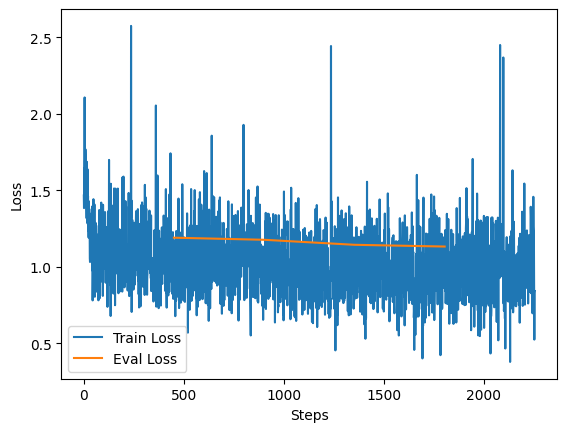

In [29]:
import matplotlib.pyplot as plt


train_losses = []
eval_losses = []
train_steps = []
eval_steps = []


for entry in trainer.state.log_history:
    if 'loss' in entry:
        train_losses.append(entry['loss'])
        train_steps.append(entry['step'])
    if 'eval_loss' in entry:
        eval_losses.append(entry['eval_loss'])
        eval_steps.append(entry['step'])


plt.plot(train_steps, train_losses, label='Train Loss')
plt.plot(eval_steps, eval_losses, label='Eval Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:

model.config.use_cache = True

In [31]:
evaluation("base", tokenizer) 

eval_model is on: cuda:0
input_ids are on: cuda:0
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

What does Bitcoin mining achieve?<|eot_id|><|start_header_id|>assistant<|end_header_id|>



`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Bitcoin 

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


mining is the process of verifying and adding new transactions to the public ledger, known as the blockchain, in the Bitcoin network. Miners use powerful computers to solve complex mathematical problems, which helps to secure the network and verify transactions. The process of mining achieves several key goals:

1. **Verification of transactions**: Miners verify the validity of each transaction, ensuring that the sender has the necessary funds, and that the transaction is legitimate.
2. **Creation of new blocks**: Miners group verified
Correct Answer: Validates transactions and secures the network by adding new blocks to the blockchain through solving SHA-256 hash problems.



eval_model is on: cuda:0
input_ids are on: cuda:0
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

How are Bitcoin transactions verified?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Bitcoin transactions are verified through a process called "mining," which is performed by specialized compute

In [40]:
# checkpoint = save_dir + '/checkpoint-1'
# evaluation("fine-tuned", checkpoint)

In [41]:
# checkpoint = save_dir + '/checkpoint-15'
# evaluation("fine-tuned", checkpoint)

In [42]:
# checkpoint = save_dir + '/checkpoint-30'
# evaluation("fine-tuned", checkpoint)

In [43]:
# checkpoint = save_dir + '/checkpoint-45'
# evaluation("fine-tuned", checkpoint)

In [44]:
# checkpoint = save_dir + '/checkpoint-60'
# evaluation("fine-tuned", checkpoint)

In [32]:
adapter_model = f"SolaireOfTheSun/{model_name}-{fine_tune_tag}-adapters"
new_model = f"SolaireOfTheSun/{model_name}-{fine_tune_tag}" #adjust 'Trelis' to your HuggingFace organisation

In [33]:
model.save_pretrained(f"{model_name}-{fine_tune_tag}-adapters-local", push_to_hub=True, use_auth_token=True)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NousResearch--Meta-Llama-3-8B-Instruct/snapshots/8238378c1ceb9e54cf8d927813c7394be99d6984/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 8192,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 500000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.38.1",
  "use_cache": true,
  "vocab_size": 128256
}



In [35]:
from huggingface_hub import notebook_login
notebook_login()

In [36]:
model.push_to_hub(adapter_model, use_auth_token=True, max_shard_size="10GB", use_safetensors=True)

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:834: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NousResearch--Meta-Llama-3-8B-Instruct/snapshots/8238378c1ceb9e54cf8d927813c7394be99d6984/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 8192,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 500000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16"

adapter_model.safetensors:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/SolaireOfTheSun/Meta-Llama-3-8B-Instruct-DHBW-Bio-Deutsch-EducationAID-adapters/commit/480c0156b6e80dc07dbf090e5b71395e21034014', commit_message='Upload model', commit_description='', oid='480c0156b6e80dc07dbf090e5b71395e21034014', pr_url=None, pr_revision=None, pr_num=None)

In [37]:

from huggingface_hub import HfApi, create_repo, create_branch

create_repo(new_model, private=True)

create_branch(new_model, repo_type="model", branch="gguf")


api = HfApi()


repo_id = adapter_model


local_file_paths = [
    save_dir + "/trainable_params_final.bin",
]


for local_file_path in local_file_paths:

    file_name = local_file_path.split("/")[-1]

    
    path_in_repo = file_name

    
    api.upload_file(
        path_or_fileobj=local_file_path,
        path_in_repo=path_in_repo,
        repo_id=repo_id,
        repo_type="model",  
    )
    print(f"Uploaded {file_name} to {repo_id}")

trainable_params_final.bin:   0%|          | 0.00/42.1M [00:00<?, ?B/s]

Uploaded trainable_params_final.bin to SolaireOfTheSun/Meta-Llama-3-8B-Instruct-DHBW-Bio-Deutsch-EducationAID-adapters


In [39]:
model = model.merge_and_unload()

In [40]:
model.generation_config.temperature=1.0

In [41]:
model.save_pretrained(f"{model_name}-{fine_tune_tag}-local")


tokenizer.save_pretrained(f"{model_name}-{fine_tune_tag}-local")

Configuration saved in Meta-Llama-3-8B-Instruct-DHBW-Bio-Deutsch-EducationAID-local/config.json
Configuration saved in Meta-Llama-3-8B-Instruct-DHBW-Bio-Deutsch-EducationAID-local/generation_config.json
The model is bigger than the maximum size per checkpoint (5GB) and is going to be split in 4 checkpoint shards. You can find where each parameters has been saved in the index located at Meta-Llama-3-8B-Instruct-DHBW-Bio-Deutsch-EducationAID-local/model.safetensors.index.json.
tokenizer config file saved in Meta-Llama-3-8B-Instruct-DHBW-Bio-Deutsch-EducationAID-local/tokenizer_config.json
Special tokens file saved in Meta-Llama-3-8B-Instruct-DHBW-Bio-Deutsch-EducationAID-local/special_tokens_map.json


('Meta-Llama-3-8B-Instruct-DHBW-Bio-Deutsch-EducationAID-local/tokenizer_config.json',
 'Meta-Llama-3-8B-Instruct-DHBW-Bio-Deutsch-EducationAID-local/special_tokens_map.json',
 'Meta-Llama-3-8B-Instruct-DHBW-Bio-Deutsch-EducationAID-local/tokenizer.json')

In [42]:
tokenizer.chat_template = "{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{%- set ns = namespace(found=false) -%}{%- for message in messages -%}{%- if message['role'] == 'system' -%}{%- set ns.found = true -%}{%- endif -%}{%- endfor -%}{{bos_token}}{%- if not ns.found -%}{{'You are an AI assistant and you do your best to answer all questions and requests\n'}}{%- endif %}{%- for message in messages %}{%- if message['role'] == 'system' %}{{ message['content'] }}{%- else %}{%- if message['role'] == 'user' %}{{'Instruction:' + message['content'] + '\n'}}{%- else %}{{'\nOutput:' + message['content'] + '\n<|EOT|>\n'}}{%- endif %}{%- endif %}{%- endfor %}{% if add_generation_prompt %}{{'\nOutput:'}}{% endif %}"

tokenizer.push_to_hub(new_model, use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:834: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
tokenizer config file saved in /tmp/tmp3y701ksa/tokenizer_config.json
Special tokens file saved in /tmp/tmp3y701ksa/special_tokens_map.json
Uploading the following files to SolaireOfTheSun/Meta-Llama-3-8B-Instruct-DHBW-Bio-Deutsch-EducationAID: tokenizer_config.json,special_tokens_map.json,tokenizer.json,README.md


CommitInfo(commit_url='https://huggingface.co/SolaireOfTheSun/Meta-Llama-3-8B-Instruct-DHBW-Bio-Deutsch-EducationAID/commit/3d7019b64b4c492d51869e0c71be5c9bc433ac6e', commit_message='Upload tokenizer', commit_description='', oid='3d7019b64b4c492d51869e0c71be5c9bc433ac6e', pr_url=None, pr_revision=None, pr_num=None)

In [43]:
model.push_to_hub(new_model, use_auth_token=True, max_shard_size="10GB", use_safetensors=True)

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

Configuration saved in /tmp/tmpubye7ieq/config.json
Configuration saved in /tmp/tmpubye7ieq/generation_config.json
The model is bigger than the maximum size per checkpoint (10GB) and is going to be split in 2 checkpoint shards. You can find where each parameters has been saved in the index located at /tmp/tmpubye7ieq/model.safetensors.index.json.
Uploading the following files to SolaireOfTheSun/Meta-Llama-3-8B-Instruct-DHBW-Bio-Deutsch-EducationAID: config.json,generation_config.json,model-00001-of-00002.safetensors,model-00002-of-00002.safetensors,model.safetensors.index.json,README.md


model-00002-of-00002.safetensors:   0%|          | 0.00/6.08G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/SolaireOfTheSun/Meta-Llama-3-8B-Instruct-DHBW-Bio-Deutsch-EducationAID/commit/aff75985bf452a1b53a1fcbb2ad3063accea3024', commit_message='Upload LlamaForCausalLM', commit_description='', oid='aff75985bf452a1b53a1fcbb2ad3063accea3024', pr_url=None, pr_revision=None, pr_num=None)

In [44]:
import os
import requests
from huggingface_hub import HfApi

def download_file_from_huggingface(model_id, filename, save_path):
    url = f"https://huggingface.co/{model_id}/resolve/main/{filename}"
    r = requests.get(url)
    if r.status_code != 200:
        print(f"Failed to download {filename}. HTTP Status Code: {r.status_code}")
        return False
    with open(os.path.join(save_path, filename), 'wb') as f:
        f.write(r.content)
    return True

def main():
 
    files_to_process = ["tokenizer.model", "README.md"]
    

    save_path = "./models"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    

    api = HfApi()

 
    repo_id = new_model  

    for filename in files_to_process:
        # Download the file
        success = download_file_from_huggingface(model_id, filename, save_path)
        if success:
            print(f"Successfully downloaded {filename}")
        else:
            print(f"Failed to download {filename}")
            continue  


        local_file_path = os.path.join(save_path, filename)


        api.upload_file(
            path_or_fileobj=local_file_path,
            path_in_repo=filename, 
            repo_id=repo_id,
            repo_type="model",  
        )
        print(f"Uploaded {filename} to {repo_id}")

if __name__ == "__main__":
    main()

Failed to download tokenizer.model. HTTP Status Code: 404
Failed to download tokenizer.model
Successfully downloaded README.md
Uploaded README.md to SolaireOfTheSun/Meta-Llama-3-8B-Instruct-DHBW-Bio-Deutsch-EducationAID
